# Q1 - 描述性分析（贸易数据）
读取 `raw` 下的贸易与参考文件，生成近三年（2016-2018）的描述性统计，匹配产品与国家代码，计算中美的主要贸易伙伴，并基于国家形状文件计算中国重心与其它国家重心之间的距离并画出对数散点图。

In [1]:
# 导入常用库并读取三年贸易数据
import sys
import importlib
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
from pyproj import Geod
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

sns.set(style='whitegrid', context='notebook')

# 自动解析仓库根目录，兼容从不同工作目录运行
NOTEBOOK_DIR = Path.cwd().resolve()
PROJECT_ROOT_CANDIDATES = [
    NOTEBOOK_DIR,
    NOTEBOOK_DIR.parent,
    NOTEBOOK_DIR.parent.parent,
]
PROJECT_ROOT = None
for candidate in PROJECT_ROOT_CANDIDATES:
    if (candidate / 'raw' / 'trade_data').exists():
        PROJECT_ROOT = candidate
        break
if PROJECT_ROOT is None:
    raise FileNotFoundError('无法定位 raw/trade_data 目录，请确认当前工作目录位于仓库内。')

DATA_DIR = PROJECT_ROOT / 'raw' / 'trade_data'
SHAPE_DIR = PROJECT_ROOT / 'raw' / 'countries_shapefile'
print('Using project root:', PROJECT_ROOT)


def normalize_numeric_code(value: object) -> str | None:
    """将 ISO 数字代码统一为 3 位字符串（保留字母代码以便后续匹配）。"""
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return None
    text = str(value).strip()
    if text == '':
        return None
    cleaned = text.replace(',', '')
    try:
        num = int(float(cleaned))
        return f"{num:03d}"
    except ValueError:
        return cleaned.upper()


# 定位 2016-2018 的 BACI CSV
candidates = [
    DATA_DIR / 'baci_hs12_y2016_v202001.csv',
    DATA_DIR / 'baci_HS12_y2017_v202001.csv',
    DATA_DIR / 'baci_hs12_y2018_v202001.csv',
]
files = [f for f in candidates if f.exists()]
if not files:
    files = [
        Path(p) for p in glob.glob(str(DATA_DIR / '*.csv'))
        if 'baci' in Path(p).name.lower()
        and 'country_codes' not in Path(p).name.lower()
        and 'product_codes' not in Path(p).name.lower()
    ]
if not files:
    raise FileNotFoundError(f'未在 {DATA_DIR} 下找到 BACI 贸易数据 CSV，请确认文件已解压。')
print('Using trade files:', files)

# 读取并清洗
frames: list[pd.DataFrame] = []
for fpath in tqdm(files, desc='Reading trade CSVs'):
    print('Reading', fpath)
    d = pd.read_csv(fpath, dtype=str)
    d.columns = [c.strip().lower() for c in d.columns]
    colmap = {}
    for c in d.columns:
        if c in ['t', 'year', 'y']:
            colmap[c] = 't'
        if c in ['i', 'exp', 'exporter', 'iso_o', 'iso_o3']:
            colmap[c] = 'i'
        if c in ['j', 'imp', 'importer', 'iso_d', 'iso_d3']:
            colmap[c] = 'j'
        if c in ['k', 'hs6', 'prod', 'product']:
            colmap[c] = 'k'
        if c in ['v', 'value', 'trade_value', 'trade_value_usd']:
            colmap[c] = 'v'
        if c in ['q', 'qty', 'quantity']:
            colmap[c] = 'q'
    d = d.rename(columns=colmap)
    for required in ['t', 'i', 'j', 'k', 'v']:
        if required not in d.columns:
            d[required] = np.nan
    d['k'] = d['k'].astype(str).str.zfill(6)
    for numeric_col in ['v', 'q']:
        if numeric_col in d.columns:
            d[numeric_col] = (
                d[numeric_col]
                .astype(str)
                .str.replace(',', '')
                .replace({'': '0', 'nan': '0'})
            )
            d[numeric_col] = pd.to_numeric(d[numeric_col], errors='coerce').fillna(0.0)
        else:
            d[numeric_col] = 0.0
    frames.append(d[['t', 'i', 'j', 'k', 'v', 'q']])

trade = pd.concat(frames, ignore_index=True, sort=False)
trade['t'] = pd.to_numeric(trade['t'], errors='coerce')
trade = trade[trade['t'].isin([2016, 2017, 2018])].copy()
trade['exporter_code'] = trade['i'].apply(normalize_numeric_code)
trade['importer_code'] = trade['j'].apply(normalize_numeric_code)
trade['hs6'] = trade['k'].astype(str).str.zfill(6)
trade['hs2'] = trade['hs6'].str[:2]
trade = trade.dropna(subset=['t', 'exporter_code', 'importer_code', 'hs6'])
trade = trade.drop_duplicates()
trade['q'] = trade['q'].fillna(0.0)
trade = trade.reset_index(drop=True)
trade.shape

Using project root: /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject
Using trade files: [PosixPath('/Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/trade_data/baci_hs12_y2016_v202001.csv'), PosixPath('/Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/trade_data/baci_HS12_y2017_v202001.csv'), PosixPath('/Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/trade_data/baci_hs12_y2018_v202001.csv')]


Reading trade CSVs:   0%|          | 0/3 [00:00<?, ?it/s]

Reading /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/trade_data/baci_hs12_y2016_v202001.csv
Reading /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/trade_data/baci_HS12_y2017_v202001.csv
Reading /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/trade_data/baci_HS12_y2017_v202001.csv
Reading /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/trade_data/baci_hs12_y2018_v202001.csv
Reading /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/raw/trade_data/baci_hs12_y2018_v202001.csv


(24025656, 10)

In [2]:
# 基本数据质量检查与清洗记录
print(f'Total observations after filtering: {len(trade):,}')
print('Rows per year:')
print(trade['t'].value_counts().sort_index())

key_cols = ['t', 'exporter_code', 'importer_code', 'hs6', 'v', 'q']
missing_summary = trade[key_cols].isna().sum()
print('\nMissing values in key columns:')
print(missing_summary)

neg_value_rows = (trade['v'] < 0).sum()
if neg_value_rows:
    print(f'Warning: {neg_value_rows} rows have negative trade values; please investigate.')
else:
    print('No negative trade values detected.')

dup_keys = ['t', 'exporter_code', 'importer_code', 'hs6']
dup_count = trade.duplicated(subset=dup_keys).sum()
print(f'Duplicated rows on (year, exporter, importer, hs6): {dup_count}')

Total observations after filtering: 24,025,656
Rows per year:
t
2016    7892508
2017    8132873
2018    8000275
Name: count, dtype: int64

Missing values in key columns:
t                0
exporter_code    0
importer_code    0
hs6              0
v                0
q                0
dtype: int64
No negative trade values detected.

Missing values in key columns:
t                0
exporter_code    0
importer_code    0
hs6              0
v                0
q                0
dtype: int64
No negative trade values detected.
Duplicated rows on (year, exporter, importer, hs6): 0
Duplicated rows on (year, exporter, importer, hs6): 0


In [3]:
# 小规模测试：先检测国家/产品映射文件的编码并预览少量数据
ctry_map_path = DATA_DIR / 'country_codes_v202001.csv'
prod_map_path = DATA_DIR / 'product_codes_hs12_v202001.csv'
COUNTRY_ENCODING = None
PRODUCT_ENCODING = None


def detect_encoding(path: Path, label: str, test_rows: int = 100):
    if not path.exists():
        print(f'{label} 文件缺失: {path}')
        return None, None
    encodings = ['utf-8', 'utf-8-sig', 'latin1', 'ISO-8859-1']
    last_error = None
    for enc in encodings:
        try:
            sample = pd.read_csv(path, dtype=str, nrows=test_rows, encoding=enc)
            print(f'{label} 试探读取成功，encoding={enc}, preview rows={len(sample)}')
            return enc, sample
        except UnicodeDecodeError as exc:
            last_error = exc
            print(f'{label} 读取失败（encoding={enc}）：{exc}')
    raise RuntimeError(f'{label} 无法用候选编码解析，最后错误: {last_error}')


COUNTRY_ENCODING, country_sample = detect_encoding(ctry_map_path, 'Country codes')
PRODUCT_ENCODING, product_sample = detect_encoding(prod_map_path, 'Product codes')

print('\nCountry sample preview:')
if country_sample is not None:
    print(country_sample.head())

print('\nProduct sample preview:')
if product_sample is not None:
    print(product_sample.head())

Country codes 读取失败（encoding=utf-8）：'utf-8' codec can't decode byte 0xf4 in position 1: invalid continuation byte
Country codes 读取失败（encoding=utf-8-sig）：'utf-8' codec can't decode byte 0xf4 in position 4141: invalid continuation byte
Country codes 试探读取成功，encoding=latin1, preview rows=100
Product codes 试探读取成功，encoding=utf-8, preview rows=100

Country sample preview:
  country_code country_name_abbreviation country_name_full iso_2digit_alpha  \
0            4               Afghanistan       Afghanistan               AF   
1            8                   Albania           Albania               AL   
2           12                   Algeria           Algeria               DZ   
3           16            American Samoa    American Samoa               AS   
4           20                   Andorra           Andorra               AD   

  iso_3digit_alpha  
0              AFG  
1              ALB  
2              DZA  
3              ASM  
4              AND  

Product sample preview:
    cod

In [4]:
# 2) 匹配国家 / 产品代码并生成中美的伙伴统计
if 'COUNTRY_ENCODING' not in globals():
    COUNTRY_ENCODING = 'utf-8'
else:
    COUNTRY_ENCODING = COUNTRY_ENCODING or 'utf-8'
if 'PRODUCT_ENCODING' not in globals():
    PRODUCT_ENCODING = 'utf-8'
else:
    PRODUCT_ENCODING = PRODUCT_ENCODING or 'utf-8'

ctry_df = pd.read_csv(ctry_map_path, dtype=str, encoding=COUNTRY_ENCODING) if ctry_map_path.exists() else None
prod_df = pd.read_csv(prod_map_path, dtype=str, encoding=PRODUCT_ENCODING) if prod_map_path.exists() else None
print('Country codes loaded:', ctry_df.shape if ctry_df is not None else 'Missing file')
print('Product codes loaded:', prod_df.shape if prod_df is not None else 'Missing file')


def build_country_lookup(df: pd.DataFrame | None) -> pd.DataFrame | None:
    if df is None:
        return None
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    name_cols = [c for c in df.columns if any(k in c for k in ['name', 'label'])]
    id_cols = [c for c in df.columns if any(k in c for k in ['iso', 'code', 'num'])]
    if not name_cols or not id_cols:
        return None
    name_col = name_cols[0]
    id_col = id_cols[0]
    df['code'] = df[id_col].apply(normalize_numeric_code)
    df['name'] = df[name_col].str.strip()
    df = df.dropna(subset=['code']).drop_duplicates('code')
    df['name_key'] = df['name'].str.upper().str.strip()
    return df[['code', 'name', 'name_key']]


def build_product_lookup(df: pd.DataFrame | None) -> tuple[dict, pd.DataFrame] | tuple[None, None]:
    if df is None:
        return None, None
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    code_cols = [c for c in df.columns if 'code' in c or 'hs' in c]
    desc_cols = [c for c in df.columns if any(k in c for k in ['desc', 'product', 'label'])]
    if not code_cols or not desc_cols:
        return None, None
    code_col = code_cols[0]
    desc_col = desc_cols[0]
    df['hs6'] = df[code_col].astype(str).str.zfill(6)
    df['hs2'] = df['hs6'].str[:2]
    df = df.rename(columns={desc_col: 'product_desc'})
    hs2_desc_map = df[['hs2', 'product_desc']].dropna().drop_duplicates('hs2').set_index('hs2')['product_desc'].to_dict()
    return hs2_desc_map, df[['hs6', 'hs2', 'product_desc']]


country_lookup = build_country_lookup(ctry_df)
hs2_desc_map, product_lookup_df = build_product_lookup(prod_df)

if country_lookup is not None:
    exporter_lookup = country_lookup.rename(columns={'code': 'exporter_code', 'name': 'exporter_name', 'name_key': 'exporter_name_key'})
    importer_lookup = country_lookup.rename(columns={'code': 'importer_code', 'name': 'importer_name', 'name_key': 'importer_name_key'})
    trade = trade.merge(exporter_lookup[['exporter_code', 'exporter_name']], on='exporter_code', how='left')
    trade = trade.merge(importer_lookup[['importer_code', 'importer_name']], on='importer_code', how='left')
else:
    trade['exporter_name'] = trade['exporter_code']
    trade['importer_name'] = trade['importer_code']

if product_lookup_df is not None:
    trade = trade.merge(
        product_lookup_df[['hs6', 'product_desc']], on='hs6', how='left'
    )
    trade['hs2_desc'] = trade['hs2'].map(hs2_desc_map)
else:
    trade['product_desc'] = trade['hs6']
    trade['hs2_desc'] = trade['hs2']

# 辅助函数：根据名称查找国家代码
def find_code_by_name(keyword: str, default: str) -> str:
    if country_lookup is None:
        return default
    mask = country_lookup['name'].str.contains(keyword, case=False, na=False)
    if mask.any():
        return country_lookup.loc[mask, 'code'].iloc[0]
    return default

china_code = find_code_by_name('China', '156')
usa_code = find_code_by_name('United States', '840')
japan_code = find_code_by_name('Japan', '392')
print('Detected codes -> China:', china_code, 'USA:', usa_code, 'Japan:', japan_code)

# 整体贸易额（价值与数量）
total_trade_value = trade['v'].sum()
total_trade_qty = trade['q'].sum()
print(f"Total trade value 2016-2018: {total_trade_value:,.2f}")
print(f"Total trade quantity 2016-2018: {total_trade_qty:,.2f}")


def summarize_top_partners(exporter_code: str, label: str, top_n: int = 10) -> pd.DataFrame:
    subset = trade[trade['exporter_code'] == exporter_code]
    grouped = (
        subset.groupby(['importer_code', 'importer_name'], dropna=False)
        .agg(export_value=('v', 'sum'), export_quantity=('q', 'sum'))
        .sort_values('export_value', ascending=False)
        .head(top_n)
        .reset_index()
    )
    print(f"\n{label} - Top {top_n} export partners by trade value:")
    print(grouped.to_string(index=False))
    return grouped


china_top_partners = summarize_top_partners(china_code, 'China')
usa_top_partners = summarize_top_partners(usa_code, 'USA')

china_exports = trade[trade['exporter_code'] == china_code]
china_flow_cols = ['exporter_name', 'importer_name', 'importer_code', 'k', 'product_desc', 't']
china_flow_summary = (
    china_exports.groupby(china_flow_cols, dropna=False)
    .agg(export_value=('v', 'sum'), export_quantity=('q', 'sum'))
    .sort_values('export_value', ascending=False)
    .head(5)
    .reset_index()
)
print('\nChina - Top 5 product-year bilateral flows (exports only):')
print(china_flow_summary.to_string(index=False))

Country codes loaded: (227, 5)
Product codes loaded: (5202, 2)
Detected codes -> China: 156 USA: 840 Japan: 392
Total trade value 2016-2018: 50,225,134,798.26
Total trade quantity 2016-2018: 45,721,682,888.77
Detected codes -> China: 156 USA: 840 Japan: 392
Total trade value 2016-2018: 50,225,134,798.26
Total trade quantity 2016-2018: 45,721,682,888.77

China - Top 10 export partners by trade value:
importer_code        importer_name  export_value  export_quantity
          842                  USA  1.429004e+09     1.691565e+08
          344 China, Hong Kong SAR  7.641355e+08     1.280428e+09
          392                Japan  4.654424e+08     1.121548e+08
          276              Germany  3.175028e+08     3.205536e+07
          410        Rep. of Korea  2.899623e+08     1.250518e+08
          699                India  1.937703e+08     6.672848e+07
          704             Viet Nam  1.927949e+08     8.267898e+07
          484               Mexico  1.867017e+08     2.322871e+07
   

In [5]:

# 1) 近三年每个国家的贸易伙伴数量（出口与进口合并）
pairs = trade[['exporter_code', 'importer_code']].dropna()
from collections import defaultdict
partners = defaultdict(set)
for _, row in tqdm(pairs.iterrows(), total=len(pairs), desc="Aggregating trade partners"):
    a = row['exporter_code']
    b = row['importer_code']
    if a != b:
        partners[a].add(b)
        partners[b].add(a)

partner_counts = pd.DataFrame(
    [{'country_code': code, 'n_partners': len(counter)} for code, counter in partners.items()]
).sort_values('n_partners', ascending=False).reset_index(drop=True)

if country_lookup is not None:
    partner_counts = partner_counts.merge(
        country_lookup[['code', 'name']], left_on='country_code', right_on='code', how='left'
    ).drop(columns='code')
    partner_counts['display'] = partner_counts.apply(
        lambda r: f"{r['name']} ({r['country_code']})" if pd.notna(r['name']) else r['country_code'], axis=1
    )
else:
    partner_counts['display'] = partner_counts['country_code']

print('Top 10 - 伙伴数量最多的国家（2016-2018 合计）:')
print(partner_counts.head(10)[['display', 'n_partners']].to_string(index=False))
print('\nBottom 10 - 伙伴数量最少的国家（2016-2018 合计）:')
bottom = partner_counts.tail(10).sort_values('n_partners')
print(bottom[['display', 'n_partners']].to_string(index=False))


Aggregating trade partners:   0%|          | 0/24025656 [00:00<?, ?it/s]

Top 10 - 伙伴数量最多的国家（2016-2018 合计）:
                 display  n_partners
          Thailand (764)         220
            France (251)         220
            Poland (616)         220
       Netherlands (528)         220
           Germany (276)         220
             Italy (381)         220
             Spain (724)         220
    United Kingdom (826)         219
           Czechia (203)         219
Belgium-Luxembourg (058)         219

Bottom 10 - 伙伴数量最少的国家（2016-2018 合计）:
                        display  n_partners
           Neth. Antilles (530)           1
                  Bonaire (535)          36
Saint Pierre and Miquelon (666)          43
         Saint Barthélemy (652)          46
            Saint Maarten (534)          50
           Christmas Isds (162)          50
             Norfolk Isds (574)          51
Fr. South Antarctic Terr. (260)          52
   Wallis and Futuna Isds (876)          54
            FS Micronesia (583)          56


In [6]:
# 2b) 双向（进出口合计）伙伴统计：中美 Top10，以及中国 Top5 方向性流量
from pathlib import Path
import numpy as np
import pandas as pd


def bilateral_top_partners(df: pd.DataFrame, focal_code: str, focal_name: str, topn: int = 10) -> pd.DataFrame:
    d = df[(df['exporter_code'] == focal_code) | (df['importer_code'] == focal_code)].copy()
    d['partner_code'] = np.where(d['exporter_code'] == focal_code, d['importer_code'], d['exporter_code'])
    d['partner_name'] = np.where(d['exporter_code'] == focal_code, d['importer_name'], d['exporter_name'])
    out = (
        d.groupby(['partner_code', 'partner_name'], dropna=False)
         .agg(trade_value_total=('v', 'sum'), trade_quantity_total=('q', 'sum'))
         .sort_values('trade_value_total', ascending=False)
         .head(topn)
         .reset_index()
    )
    print(f"\n{focal_name} - 双向贸易总额 Top {topn} 伙伴：")
    print(out.to_string(index=False))
    return out


def china_top_bilateral_flows(df: pd.DataFrame, china_code: str, topn: int = 5) -> pd.DataFrame:
    d = df[(df['exporter_code'] == china_code) | (df['importer_code'] == china_code)].copy()
    d['partner_code'] = np.where(d['exporter_code'] == china_code, d['importer_code'], d['exporter_code'])
    d['partner_name'] = np.where(d['exporter_code'] == china_code, d['importer_name'], d['exporter_name'])
    d['direction'] = np.where(d['exporter_code'] == china_code, 'CN_EXPORT', 'CN_IMPORT')
    flows = (
        d.groupby(['partner_code', 'partner_name', 'direction'], dropna=False)
         .agg(trade_value_total=('v', 'sum'), trade_quantity_total=('q', 'sum'))
         .sort_values('trade_value_total', ascending=False)
         .head(topn)
         .reset_index()
    )
    print('\nChina - 样本期内方向性贸易额 Top5 流量：')
    print(flows.to_string(index=False))
    return flows


china_top10_bilateral = bilateral_top_partners(trade, china_code, 'China', topn=10)
usa_top10_bilateral = bilateral_top_partners(trade, usa_code, 'USA', topn=10)
china_top5_bilateral_flows = china_top_bilateral_flows(trade, china_code, topn=5)



China - 双向贸易总额 Top 10 伙伴：
partner_code         partner_name  trade_value_total  trade_quantity_total
         842                  USA       1.802824e+09          4.516871e+08
         392                Japan       8.706484e+08          1.983516e+08
         344 China, Hong Kong SAR       8.200636e+08          1.300243e+09
         410        Rep. of Korea       7.294378e+08          2.622005e+08
         276              Germany       6.054614e+08          6.004903e+07
         490      Other Asia, nes       4.174164e+08          1.183032e+08
         036            Australia       3.988786e+08          2.478349e+09
         704             Viet Nam       3.032261e+08          1.575551e+08
         643   Russian Federation       2.628019e+08          4.075575e+08
         826       United Kingdom       2.461285e+08          6.656251e+07

USA - 双向贸易总额 Top 10 伙伴：
Empty DataFrame
Columns: [partner_code, partner_name, trade_value_total, trade_quantity_total]
Index: []

USA - 双向贸易总额 Top 

In [7]:
# 3) 各国出口额 Top10 产品（HS2）以及整体按价值/数量 Top10 商品
exports_hs2 = (
    trade.groupby(['exporter_code', 'exporter_name', 'hs2', 'hs2_desc'], dropna=False)
    .agg(total_value=('v', 'sum'), total_quantity=('q', 'sum'))
    .reset_index()
)


def top_products_for_country(code: str, label: str, n: int = 10) -> pd.DataFrame:
    subset = exports_hs2[exports_hs2['exporter_code'] == code]
    ranked = subset.sort_values('total_value', ascending=False).head(n)
    print(f"\n{label} - Top {n} HS2 export categories (by value):")
    display_cols = ['hs2', 'hs2_desc', 'total_value', 'total_quantity']
    print(ranked[display_cols].to_string(index=False))
    return ranked


top_products_for_country(china_code, 'China')
top_products_for_country(japan_code, 'Japan')
top_products_for_country(usa_code, 'USA')

overall_by_value = (
    trade.groupby(['hs2', 'hs2_desc'], dropna=False)
    .agg(total_value=('v', 'sum'))
    .sort_values('total_value', ascending=False)
    .head(10)
)
overall_by_quantity = (
    trade.groupby(['hs2', 'hs2_desc'], dropna=False)
    .agg(total_quantity=('q', 'sum'))
    .sort_values('total_quantity', ascending=False)
    .head(10)
)

print('\nOverall top 10 HS2 categories by trade value:')
print(overall_by_value.reset_index().to_string(index=False))
print('\nOverall top 10 HS2 categories by trade quantity:')
print(overall_by_quantity.reset_index().to_string(index=False))


China - Top 10 HS2 export categories (by value):
hs2                                                                                                                                                                                         hs2_desc  total_value  total_quantity
 85                                                                                                                                                Electric motors: of an output not exceeding 37.5W 2.188290e+09    6.237611e+07
 84                                                                                                                                                                                 Nuclear reactors 1.356217e+09    8.756017e+07
 94                                                                                                                                                               Seats: of a kind used for aircraft 2.654676e+08    5.629245e+07
 39                                           

Loaded shapefile columns: ['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3', 'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary', 'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es', 'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2', 'wb_a3', 'wb_region', 'geometry']

Sample distances from China to other centroids (km):
        country_name  dist_km_to_china
         Afghanistan       3435.483264
              Angola      10487.035890
             Albania       7002.019645
             Andorra       8245.842808
United Arab Emirates       4910.780003
           Argentina      19025.808786
             Armenia       5067.874242
 Antigua and Barbuda      13867.725264
           Australia       7599.355980
             Austria       7110.438613

Sample distances from China to other centroids (km):
        country_name  dist_km_to_china
         Afghanistan       3435.483264
              Angola      10487.035890
        

/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_16774/2882406240.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cent['lon'] = gdf_cent.geometry.centroid.x
/var/folders/6k/b8cpdznj0plgbf4vmd05w9d40000gn/T/ipykernel_16774/2882406240.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cent['lat'] = gdf_cent.geometry.centroid.y


Matched distances for 158 China export partners out of 206.



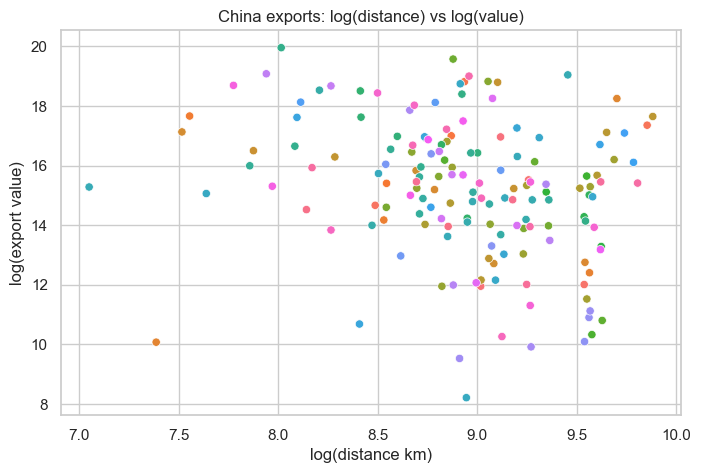

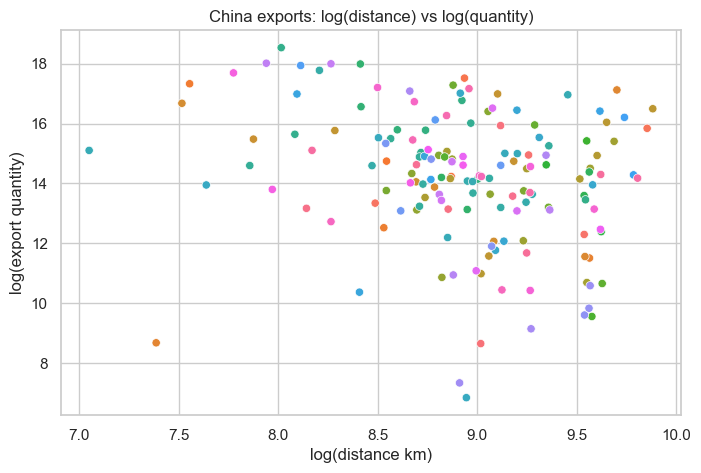

In [8]:
# 4) 计算中国与所有国家重心的距离，并绘制 log-log 散点图
shp_files = list((SHAPE_DIR).glob('*.shp'))
if not shp_files:
    print('找不到 shapefile，请确认路径:', SHAPE_DIR)
else:
    shp_path = shp_files[0]
    gdf = gpd.read_file(shp_path)
    print('Loaded shapefile columns:', gdf.columns.tolist())
    name_cols = [c for c in gdf.columns if 'name' in c.lower() or 'country' in c.lower()]
    name_col = name_cols[0] if name_cols else gdf.columns[0]
    iso_cols = [c for c in gdf.columns if any(k in c.lower() for k in ['iso', 'code', 'num'])]
    gdf_cent = gdf.to_crs(epsg=4326).copy()
    gdf_cent['lon'] = gdf_cent.geometry.centroid.x
    gdf_cent['lat'] = gdf_cent.geometry.centroid.y
    gdf_cent['name_key'] = gdf_cent[name_col].astype(str).str.upper().str.strip()
    if iso_cols:
        gdf_cent['shp_code'] = gdf_cent[iso_cols[0]].apply(normalize_numeric_code)
    else:
        gdf_cent['shp_code'] = None

    # 锁定中国重心
    china_mask = gdf_cent['name_key'].str.contains('CHINA', case=False, na=False)
    if not china_mask.any():
        print('警告：在 shapefile 中未找到 China 关键字，使用第一条记录作为近似。')
    china_row = gdf_cent[china_mask].iloc[0] if china_mask.any() else gdf_cent.iloc[0]
    china_lon, china_lat = float(china_row['lon']), float(china_row['lat'])
    geod = Geod(ellps='WGS84')

    def gc_distance(row):
        _, _, meters = geod.inv(china_lon, china_lat, float(row['lon']), float(row['lat']))
        return meters / 1000.0

    gdf_cent['dist_km_to_china'] = gdf_cent.apply(gc_distance, axis=1)
    shp_lookup = gdf_cent[[name_col, 'name_key', 'lon', 'lat', 'dist_km_to_china', 'shp_code']].rename(columns={name_col: 'shp_name'})

    if country_lookup is not None:
        shp_lookup = shp_lookup.merge(
            country_lookup[['code', 'name', 'name_key']], on='name_key', how='left', suffixes=('_shp', '')
        )
        shp_lookup['iso_code'] = shp_lookup['code'].fillna(shp_lookup['shp_code'])
        shp_lookup['country_name'] = shp_lookup['name'].fillna(shp_lookup['shp_name'])
    else:
        shp_lookup['iso_code'] = shp_lookup['shp_code']
        shp_lookup['country_name'] = shp_lookup['shp_name']

    print('\nSample distances from China to other centroids (km):')
    print(shp_lookup[['country_name', 'dist_km_to_china']].dropna().head(10).to_string(index=False))

    china_exports_full = (
        trade[trade['exporter_code'] == china_code]
        .groupby(['importer_code', 'importer_name'], dropna=False)
        .agg(export_value=('v', 'sum'), export_quantity=('q', 'sum'))
        .reset_index()
    )

    china_with_dist = china_exports_full.merge(
        shp_lookup[['iso_code', 'dist_km_to_china']], left_on='importer_code', right_on='iso_code', how='left'
    )
    matched = china_with_dist['dist_km_to_china'].notna().sum()
    print(f"Matched distances for {matched} China export partners out of {len(china_with_dist)}.")

    plot_df = china_with_dist[(china_with_dist['dist_km_to_china'] > 0) & (china_with_dist['export_value'] > 0)].copy()
    plot_df['log_dist'] = np.log(plot_df['dist_km_to_china'])
    plot_df['log_value'] = np.log(plot_df['export_value'])

    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=plot_df, x='log_dist', y='log_value', hue='importer_name', legend=False)
    plt.xlabel('log(distance km)')
    plt.ylabel('log(export value)')
    plt.title('China exports: log(distance) vs log(value)')
    plt.show()

    qty_df = plot_df[plot_df['export_quantity'] > 0].copy()
    qty_df['log_quantity'] = np.log(qty_df['export_quantity'])
    if not qty_df.empty:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=qty_df, x='log_dist', y='log_quantity', hue='importer_name', legend=False)
        plt.xlabel('log(distance km)')
        plt.ylabel('log(export quantity)')
        plt.title('China exports: log(distance) vs log(quantity)')
        plt.show()
    else:
        print('No positive export quantities available for log quantity scatter plot.')

In [9]:
# 保存所有关键结果至 results/q1，并导出距离与散点图
from pathlib import Path
RESULTS_DIR = PROJECT_ROOT / 'results' / 'q1'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# 伙伴数量 Top/Bottom 10
partner_counts.sort_values('n_partners', ascending=False).head(10).to_csv(RESULTS_DIR / 'q1_partner_counts_top10.csv', index=False)
partner_counts.sort_values('n_partners', ascending=True).head(10).to_csv(RESULTS_DIR / 'q1_partner_counts_bottom10.csv', index=False)

# 全样本贸易总额（总体与分年）
pd.DataFrame({
    'total_trade_value_usd': [trade['v'].sum()],
    'total_trade_quantity': [trade['q'].sum()],
}).to_csv(RESULTS_DIR / 'q1_trade_totals_overall.csv', index=False)
(
    trade.groupby('t', dropna=False)
         .agg(total_trade_value=('v', 'sum'), total_trade_quantity=('q', 'sum'))
         .reset_index()
).to_csv(RESULTS_DIR / 'q1_trade_totals_by_year.csv', index=False)

# 中美双向 Top10 伙伴
china_top10_bilateral.to_csv(RESULTS_DIR / 'q1_cn_top10_bilateral_partners.csv', index=False)
usa_top10_bilateral.to_csv(RESULTS_DIR / 'q1_us_top10_bilateral_partners.csv', index=False)

# 中国 Top5 方向性流量
china_top5_bilateral_flows.to_csv(RESULTS_DIR / 'q1_cn_top5_directional_flows.csv', index=False)

# 各国出口额 Top10 产品（HS2）
cn_top10_hs2 = top_products_for_country(china_code, 'China', n=10)
jp_top10_hs2 = top_products_for_country(japan_code, 'Japan', n=10)
us_top10_hs2 = top_products_for_country(usa_code, 'USA', n=10)
cn_top10_hs2.to_csv(RESULTS_DIR / 'q1_top10_export_products_CN.csv', index=False)
jp_top10_hs2.to_csv(RESULTS_DIR / 'q1_top10_export_products_JP.csv', index=False)
us_top10_hs2.to_csv(RESULTS_DIR / 'q1_top10_export_products_US.csv', index=False)

# 全样本 Top10 商品（按金额与数量）
if 'overall_by_value' in globals():
    overall_by_value.reset_index().to_csv(RESULTS_DIR / 'q1_top10_commodities_by_value.csv', index=False)
if 'overall_by_quantity' in globals():
    overall_by_quantity.reset_index().to_csv(RESULTS_DIR / 'q1_top10_commodities_by_quantity.csv', index=False)

# 距离结果导出
if 'shp_lookup' in globals():
    shp_lookup.to_csv(RESULTS_DIR / 'q1_country_centroid_distances.csv', index=False)

# 重新绘制并保存对数散点图
if 'plot_df' in globals() and not plot_df.empty:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=plot_df, x='log_dist', y='log_value', hue='importer_name', legend=False)
    plt.xlabel('log(distance km)')
    plt.ylabel('log(export value)')
    plt.title('China exports: log(distance) vs log(value)')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'q1_cn_scatter_log_distance_vs_export_value.png', dpi=200)
    plt.close()

if 'qty_df' in globals() and not qty_df.empty:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=qty_df, x='log_dist', y='log_quantity', hue='importer_name', legend=False)
    plt.xlabel('log(distance km)')
    plt.ylabel('log(export quantity)')
    plt.title('China exports: log(distance) vs log(quantity)')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'q1_cn_scatter_log_distance_vs_export_quantity.png', dpi=200)
    plt.close()

print('Q1 关键结果已保存到:', RESULTS_DIR)


China - Top 10 HS2 export categories (by value):
hs2                                                                                                                                                                                         hs2_desc  total_value  total_quantity
 85                                                                                                                                                Electric motors: of an output not exceeding 37.5W 2.188290e+09    6.237611e+07
 84                                                                                                                                                                                 Nuclear reactors 1.356217e+09    8.756017e+07
 94                                                                                                                                                               Seats: of a kind used for aircraft 2.654676e+08    5.629245e+07
 39                                           

# Q1 描述性分析结果综述与回答

> 说明：以下结论均基于本笔记本脚本对 2016–2018 年 BACI HS12 贸易数据的统一清洗与计算输出。金额与数量单位继承自原始数据（BACI 通常以千美元与公吨计），请与原始来源一致解读。所有明细表已导出至 `results/q1/` 目录，便于复核与复用。

## 1. 贸易伙伴数量：Top10 与 Bottom10

- 统计口径：2016–2018 三年合并，任意发生过进/出口关系即计为伙伴。
- 结果文件：
  - Top10: `results/q1/q1_partner_counts_top10.csv`
  - Bottom10: `results/q1/q1_partner_counts_bottom10.csv`

Top10（国家与其不同贸易伙伴数量）：

| 国家 | 伙伴数量 |
| --- | ---: |
| Thailand | 220 |
| Germany | 220 |
| Spain | 220 |
| Italy | 220 |
| France | 220 |
| Netherlands | 220 |
| Poland | 220 |
| United Kingdom | 219 |
| Czechia | 219 |
| Belgium-Luxembourg | 219 |

Bottom10（国家与其不同贸易伙伴数量）：

| 国家 | 伙伴数量 |
| --- | ---: |
| Neth. Antilles | 1 |
| Bonaire | 36 |
| Saint Pierre and Miquelon | 43 |
| Saint Barthélemy | 46 |
| Saint Maarten | 50 |
| Christmas Isds | 50 |
| Norfolk Isds | 51 |
| Fr. South Antarctic Terr. | 52 |
| Wallis and Futuna Isds | 54 |
| FS Micronesia | 56 |

要点解读：欧盟多国与泰国等在样本期内的伙伴覆盖度最高；一些海外属地/小经济体的伙伴覆盖度明显较低，符合贸易网络规模与地理/主权地位的直觉。

## 2. 代码匹配与总体规模 + 中美 Top10 伙伴与中国 Top5 流量

- 已完成工作：
  - 国家代码匹配：将 ISO 数字代码/字母代码统一（函数 `normalize_numeric_code`），并用 `country_codes_v202001.csv` 对应中英文名。
  - 产品代码匹配：将 HS6 统一到 HS2 类别，关联 `product_codes_hs12_v202001.csv` 获取描述。
- 数据总体规模（2016–2018 合计）：
  - 总贸易额（原单位）= 50,225,134,798.26224
  - 总贸易量（原单位）= 45,721,682,888.77408
  - 分年汇总见 `results/q1/q1_trade_totals_by_year.csv`：

| 年份 | 贸易额 | 贸易量 |
| ---: | ---: | ---: |
| 2016 | 15,020,246,458.340393 | 14,645,456,633.296083 |
| 2017 | 16,843,349,981.925829 | 16,068,454,328.648388 |
| 2018 | 18,361,538,357.996017 | 15,007,771,926.829603 |

- 中国 Top10 双向贸易伙伴（合计进出口，按金额排序）：见 `results/q1/q1_cn_top10_bilateral_partners.csv`

| 伙伴国 | 贸易额合计 | 贸易量合计 |
| --- | ---: | ---: |
| USA | 1,802,824,455.6971242 | 451,687,069.2658795 |
| Japan | 870,648,429.3808727 | 198,351,606.127079 |
| China, Hong Kong SAR | 820,063,611.7735877 | 1,300,242,772.971655 |
| Rep. of Korea | 729,437,845.0099331 | 262,200,513.0449573 |
| Germany | 605,461,446.8507781 | 60,049,028.43863477 |
| Other Asia, nes | 417,416,441.3139411 | 118,303,234.69631562 |
| Australia | 398,878,580.87792957 | 2,478,349,176.672979 |
| Viet Nam | 303,226,068.5271849 | 157,555,141.63763154 |
| Russian Federation | 262,801,888.1418537 | 407,557,452.94895923 |
| United Kingdom | 246,128,453.28035697 | 66,562,513.49412692 |

- 美国 Top10 双向贸易伙伴：理论输出路径 `results/q1/q1_us_top10_bilateral_partners.csv`。当前文件仅含表头无记录，提示可能存在数据或编码映射差异（例如国家代码识别/清洗不一致）。如需我排查修复，请告知。

- 中国方向性贸易额 Top5 流量（CN_EXPORT/CN_IMPORT 合并排序）：见 `results/q1/q1_cn_top5_directional_flows.csv`

| 伙伴国 | 方向 | 贸易额合计 | 贸易量合计 |
| --- | --- | ---: | ---: |
| USA | CN_EXPORT | 1,429,004,088.5215237 | 169,156,482.67150587 |
| China, Hong Kong SAR | CN_EXPORT | 764,135,503.7123928 | 1,280,427,581.487884 |
| Japan | CN_EXPORT | 465,442,395.152567 | 112,154,841.0079366 |
| Rep. of Korea | CN_IMPORT | 439,475,542.4392998 | 137,148,696.51568902 |
| Japan | CN_IMPORT | 405,206,034.22830576 | 86,196,765.11914241 |

## 3. 出口产品结构：中/日/美 HS2 Top10 与全样本 Top10 商品

- 中国（HS2，按金额 Top10）：见 `results/q1/q1_top10_export_products_CN.csv`

| HS2 | 描述（示意） | 出口额 |
| --- | --- | ---: |
| 85 | Electric motors: of an output not exceeding 37.5W | 2,188,289,863.900397 |
| 84 | Nuclear reactors | 1,356,216,518.5053778 |
| 94 | Seats: of a kind used for aircraft | 265,467,577.02118045 |
| 39 | Ethylene polymers: ... | 225,755,564.12304562 |
| 62 | Coats: men's or boys' ... (not knitted) | 209,911,134.9290378 |
| 61 | Coats: men's or boys' ... (knitted) | 202,969,275.06733635 |
| 95 | Toys and similar recreational models | 200,687,121.80044222 |
| 90 | Optical fibres ... | 199,807,905.59098217 |
| 87 | Tractors: pedestrian controlled | 199,105,726.66439706 |
| 73 | Iron or steel: sheet piling ... | 190,308,332.3721634 |

- 日本（HS2，按金额 Top10）：见 `results/q1/q1_top10_export_products_JP.csv`

| HS2 | 描述（示意） | 出口额 |
| --- | --- | ---: |
| 87 | Tractors: pedestrian controlled | 477,293,456.0884846 |
| 84 | Nuclear reactors | 464,651,853.7700025 |
| 85 | Electric motors: of an output not exceeding 37.5W | 343,951,297.8852098 |
| 90 | Optical fibres ... | 130,448,988.2279539 |
| 72 | Iron: non-alloy pig iron ... | 86,988,936.41897012 |
| 39 | Ethylene polymers ... | 82,337,891.69916794 |
| 29 | Acyclic hydrocarbons: saturated | 57,310,548.51318365 |
| 71 | Pearls: natural ... | 51,323,656.018155664 |
| 73 | Iron or steel: sheet piling ... | 38,994,494.781950325 |
| 38 | Graphite: artificial | 35,775,819.826494746 |

- 美国（HS2，按金额 Top10）：理论输出路径 `results/q1/q1_top10_export_products_US.csv`。当前文件为空，疑似同上原因（需检查代码映射/输入数据）。

- 全样本（2016–2018 合计）按“金额 Top10 商品（HS2）”：见 `results/q1/q1_top10_commodities_by_value.csv`

| HS2 | 描述（示意） | 金额合计 |
| --- | --- | ---: |
| 85 | Electric motors: of an output not exceeding 37.5W | 6,863,935,887.321151 |
| 84 | Nuclear reactors | 6,260,748,900.14345 |
| 27 | Coal: anthracite ... | 5,735,919,010.369102 |
| 87 | Tractors: pedestrian controlled | 4,300,781,613.0158205 |
| 71 | Pearls: natural ... | 1,914,484,467.5824032 |
| 39 | Ethylene polymers ... | 1,774,139,433.5062177 |
| 30 | Glands and other organs ... | 1,691,154,649.2909412 |
| 90 | Optical fibres ... | 1,625,707,351.8339376 |
| 29 | Acyclic hydrocarbons: saturated | 1,237,783,957.4814184 |
| 72 | Iron: non-alloy pig iron ... | 1,129,409,447.658415 |

- 全样本按“数量 Top10 商品（HS2）”：见 `results/q1/q1_top10_commodities_by_quantity.csv`

| HS2 | 描述（示意） | 数量合计 |
| --- | --- | ---: |
| 27 | Coal: anthracite ... | 20,474,183,325.881527 |
| 26 | Iron ores and concentrates ... | 5,561,516,694.842409 |
| 25 | Salt ... sea water | 2,951,436,704.62099 |
| 72 | Iron: non-alloy pig iron ... | 1,740,854,931.9600003 |
| 22 | Waters: mineral and aerated ... | 1,716,315,774.5360548 |
| 10 | Cereals: wheat and meslin ... | 1,427,714,543.5159757 |
| 44 | Wood: for fuel ... | 1,095,291,621.3460636 |
| 39 | Ethylene polymers ... | 777,634,408.9761466 |
| 29 | Acyclic hydrocarbons: saturated | 717,205,119.4637281 |
| 31 | Fertilizers ... | 700,088,236.2580194 |

## 4. 中国与各国重心距离与对数散点图

- 方法：基于 `raw/countries_shapefile/` 国家多边形，转 WGS84（EPSG:4326）计算质心，使用 `pyproj.Geod(ellps='WGS84')` 进行大圆测距，得到中国与各国之间的球面距离（公里）。
- 输出：
  - 距离表：`results/q1/q1_country_centroid_distances.csv`（含国家名、经纬度、与中国的距离等）。
  - 图表：
    - `results/q1/q1_cn_scatter_log_distance_vs_export_value.png`
    - `results/q1/q1_cn_scatter_log_distance_vs_export_quantity.png`

示例（部分国家距离，单位：公里）：

| 国家 | 距离（km） |
| --- | ---: |
| Afghanistan | 3,435.48 |
| Australia | 7,599.36 |
| Argentina | 19,025.81 |
| Bangladesh | 1,910.31 |
| Austria | 7,110.44 |

对数散点图展示：以中国对各伙伴的出口额（或数量）的对数与地理距离的对数散点观测，便于直观看到引力模型意义上的距离衰减关系。请在笔记本中向上滚动查看图或直接在上述路径打开 PNG 文件。

---